In [12]:
from utils import read_data
from utils import result

import xgboost as xgb

import tensorflow as tf

import os
import pandas as pd
import re
import string
import numpy as np
import json

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from gensim.models import doc2vec
import gensim
import random
from tqdm import tqdm
import xgboost as xgb

np.random.seed(202301)

import warnings
warnings.filterwarnings('ignore')

In [23]:
plt.style.use('ggplot')

In [13]:
train_sentence, test_sentence, sarcasm_sentence, train_token, test_token, sarcasm_token, y_train, y_test, y_sarcasm = read_data()

In [14]:
def tag_doc(docs):
    tagged_docs = []
    for i in range(len(docs)):
        doc = docs[i]
        tag = i
        tagged_docs.append(doc2vec.TaggedDocument(doc, [tag]))
    return tagged_docs

In [15]:
tagged_docs = tag_doc(train_token + test_token + sarcasm_token)


In [16]:
len(train_token)

47688

In [17]:
len(test_token)

10050

In [18]:
len(sarcasm_token)

86

In [19]:
%%time
xgb_epoch = [[], [], [], [], [], []]
ann_epoch = [[], [], [], [], [], []]
svc_epoch = [[], [], [], [], [], []]

vocab = train_token + test_token + sarcasm_token

for epoch in tqdm([5, 10, 100, 200, 1000]):

    doc_model = doc2vec.Doc2Vec(vector_size=300, window=5, min_count=1, workers=32)
    doc_model.build_vocab([i for i in tagged_docs])
    doc_model.train(tagged_docs, total_examples=doc_model.corpus_count, epochs=epoch)


    train_vector = [doc_model[i] for i in range(47688)]
    train_vector = np.array(train_vector)
    test_vector = [doc_model[i] for i in range(47688, 47688+10050)]
    test_vector = np.array(test_vector)
    sarcasm_vector = [doc_model[i] for i in range(47688+10050, 47688+10050+86)]
    sarcasm_vector = np.array(sarcasm_vector)

    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(300, )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)
])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(train_vector, y_train, epochs=20, verbose=0)
    pred = np.array(tf.argmax(model.predict(test_vector), axis=1))
    pred_sarcasm = np.array(tf.argmax(model.predict(sarcasm_vector), axis=1))
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    ann_epoch[0].append(r1)
    ann_epoch[1].append(r2)
    ann_epoch[2].append(r3)
    ann_epoch[3].append(r4)
    ann_epoch[4].append(r5)
    ann_epoch[5].append(r6)

    model = xgb.XGBClassifier()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    xgb_epoch[0].append(r1)
    xgb_epoch[1].append(r2)
    xgb_epoch[2].append(r3)
    xgb_epoch[3].append(r4)
    xgb_epoch[4].append(r5)
    xgb_epoch[5].append(r6)

    model = SVC()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    svc_epoch[0].append(r1)
    svc_epoch[1].append(r2)
    svc_epoch[2].append(r3)
    svc_epoch[3].append(r4)
    svc_epoch[4].append(r5)
    svc_epoch[5].append(r6)

  0%|          | 0/5 [00:00<?, ?it/s]2023-01-07 01:08:44.908589: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-07 01:08:45.072529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 64/315 [=====>........................] - ETA: 0s

2023-01-07 01:12:09.596143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 10ms/step
[01:12:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 20%|██        | 1/5 [19:21<1:17:26, 1161.73s/it]2023-01-07 01:28:19.818913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 69/315 [=====>........................] - ETA: 0s

2023-01-07 01:31:17.323986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 7ms/step
[01:31:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 40%|████      | 2/5 [38:35<57:51, 1157.11s/it]  2023-01-07 01:52:41.099939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 49/315 [===>..........................] - ETA: 0s

2023-01-07 01:57:05.636001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 9ms/step
[01:57:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 60%|██████    | 3/5 [1:08:33<48:19, 1449.60s/it]2023-01-07 02:27:06.249669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 57/315 [====>.........................] - ETA: 0s

2023-01-07 02:30:19.620094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 7ms/step
[02:30:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 80%|████████  | 4/5 [1:40:47<27:20, 1640.73s/it]2023-01-07 03:38:09.374099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 67/315 [=====>........................] - ETA: 0s

2023-01-07 03:41:31.763122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 7ms/step
[03:41:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 5/5 [2:54:32<00:00, 2094.41s/it]

CPU times: user 3h 34min 37s, sys: 57min, total: 4h 31min 38s
Wall time: 2h 54min 32s


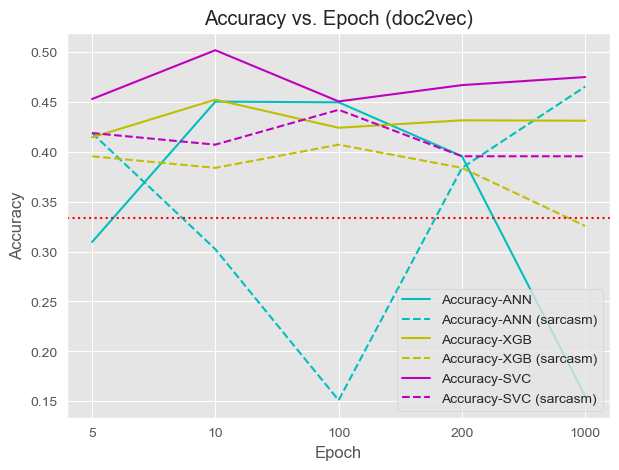

In [30]:
xgb_epoch = np.array(xgb_epoch)
ann_epoch = np.array(ann_epoch)
svc_epoch = np.array(svc_epoch)

plt.rcParams["figure.figsize"] = (7, 5)
epoch = ['5', '10', '100', '200', '1000']

x = np.arange(5)
plt.plot(x, ann_epoch[0], 'c', label='Accuracy-ANN ')
plt.plot(x, ann_epoch[3], 'c--', label='Accuracy-ANN (sarcasm)')

plt.plot(x, xgb_epoch[0], 'y', label='Accuracy-XGB')
plt.plot(x, xgb_epoch[3], 'y--', label='Accuracy-XGB (sarcasm)')

plt.plot(x, svc_epoch[0], 'm', label='Accuracy-SVC')
plt.plot(x, svc_epoch[3], 'm--', label='Accuracy-SVC (sarcasm)')

plt.xticks(np.arange(5), epoch)
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.axhline(y=1/3, color='r', linestyle='dotted')
plt.title("Accuracy vs. Epoch (doc2vec)")
plt.savefig('accuracy_doc2vec_epoch.png', dpi=1000)
plt.show()

In [20]:
%%time
xgb_size = [[], [], [], [], [], []]
ann_size = [[], [], [], [], [], []]
svc_size = [[], [], [], [], [], []]

vocab = train_token + test_token + sarcasm_token

for size in tqdm([50, 100, 200, 300, 500, 1000]):

    doc_model = doc2vec.Doc2Vec(vector_size=size, window=5, min_count=1, workers=32)
    doc_model.build_vocab([i for i in tagged_docs])
    doc_model.train(tagged_docs, total_examples=doc_model.corpus_count, epochs=100)


    train_vector = [doc_model[i] for i in range(47688)]
    train_vector = np.array(train_vector)
    test_vector = [doc_model[i] for i in range(47688, 47688+10050)]
    test_vector = np.array(test_vector)
    sarcasm_vector = [doc_model[i] for i in range(47688+10050, 47688+10050+86)]
    sarcasm_vector = np.array(sarcasm_vector)

    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(size, )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)
])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(train_vector, y_train, epochs=20, verbose=0)
    pred = np.array(tf.argmax(model.predict(test_vector), axis=1))
    pred_sarcasm = np.array(tf.argmax(model.predict(sarcasm_vector), axis=1))
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    ann_size[0].append(r1)
    ann_size[1].append(r2)
    ann_size[2].append(r3)
    ann_size[3].append(r4)
    ann_size[4].append(r5)
    ann_size[5].append(r6)

    model = xgb.XGBClassifier()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    xgb_size[0].append(r1)
    xgb_size[1].append(r2)
    xgb_size[2].append(r3)
    xgb_size[3].append(r4)
    xgb_size[4].append(r5)
    xgb_size[5].append(r6)

    model = SVC()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    svc_size[0].append(r1)
    svc_size[1].append(r2)
    svc_size[2].append(r3)
    svc_size[3].append(r4)
    svc_size[4].append(r5)
    svc_size[5].append(r6)

  0%|          | 0/6 [00:00<?, ?it/s]2023-01-07 04:08:58.008799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 63/315 [=====>........................] - ETA: 0s

2023-01-07 04:12:37.538282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 8ms/step
[04:12:38] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 17%|█▋        | 1/6 [14:05<1:10:29, 845.88s/it]2023-01-07 04:21:25.344054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 64/315 [=====>........................] - ETA: 0s

2023-01-07 04:24:29.632635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 10ms/step
[04:24:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 33%|███▎      | 2/6 [30:52<1:02:40, 940.18s/it]2023-01-07 04:38:39.225760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 71/315 [=====>........................] - ETA: 0s

2023-01-07 04:41:34.675515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 7ms/step
[04:41:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 50%|█████     | 3/6 [53:37<56:43, 1134.52s/it] 2023-01-07 05:01:22.964040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 59/315 [====>.........................] - ETA: 0s

2023-01-07 05:04:33.219641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 9ms/step
[05:04:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 67%|██████▋   | 4/6 [1:20:09<43:49, 1314.87s/it]2023-01-07 05:28:03.612870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 73/315 [=====>........................] - ETA: 0s

2023-01-07 05:31:11.195379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 8ms/step
[05:31:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 83%|████████▎ | 5/6 [1:56:00<26:56, 1616.43s/it]2023-01-07 06:03:57.641051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 66/315 [=====>........................] - ETA: 0s

2023-01-07 06:06:46.602740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 9ms/step
[06:06:50] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 6/6 [2:55:49<00:00, 1758.20s/it]

CPU times: user 3h 59min 40s, sys: 31min 56s, total: 4h 31min 36s
Wall time: 2h 55min 49s


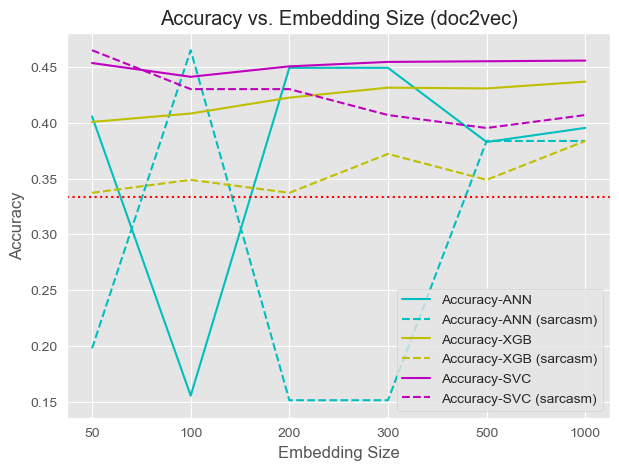

In [31]:
xgb_size = np.array(xgb_size)
ann_size = np.array(ann_size)
svc_size = np.array(svc_size)


plt.rcParams["figure.figsize"] = (7, 5)
size = [50, 100, 200, 300, 500, 1000]

x = np.arange(6)
plt.plot(x, ann_size[0], 'c', label='Accuracy-ANN ')
plt.plot(x, ann_size[3], 'c--', label='Accuracy-ANN (sarcasm)')

plt.plot(x, xgb_size[0], 'y', label='Accuracy-XGB')
plt.plot(x, xgb_size[3], 'y--', label='Accuracy-XGB (sarcasm)')

plt.plot(x, svc_size[0], 'm', label='Accuracy-SVC')
plt.plot(x, svc_size[3], 'm--', label='Accuracy-SVC (sarcasm)')

plt.xticks(np.arange(6), size)
plt.legend(loc='lower right')
plt.axhline(y=1/3, color='r', linestyle='dotted')
plt.xlabel("Embedding Size")
plt.ylabel("Accuracy")
plt.savefig('accuracy_doc2vec_embedding.png', dpi=1000)
plt.title("Accuracy vs. Embedding Size (doc2vec)")
plt.show()

In [21]:
%%time
xgb_window = [[], [], [], [], [], []]
ann_window = [[], [], [], [], [], []]
svc_window = [[], [], [], [], [], []]

vocab = train_token + test_token + sarcasm_token

for count in tqdm([1, 3, 5, 10, 20]):

    doc_model = doc2vec.Doc2Vec(vector_size=300, window=5, min_count=count, workers=32)
    doc_model.build_vocab([i for i in tagged_docs])
    doc_model.train(tagged_docs, total_examples=doc_model.corpus_count, epochs=100)


    train_vector = [doc_model[i] for i in range(47688)]
    train_vector = np.array(train_vector)
    test_vector = [doc_model[i] for i in range(47688, 47688+10050)]
    test_vector = np.array(test_vector)
    sarcasm_vector = [doc_model[i] for i in range(47688+10050, 47688+10050+86)]
    sarcasm_vector = np.array(sarcasm_vector)

    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(300, )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)
])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(train_vector, y_train, epochs=20, verbose=0)
    pred = np.array(tf.argmax(model.predict(test_vector), axis=1))
    pred_sarcasm = np.array(tf.argmax(model.predict(sarcasm_vector), axis=1))
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    ann_window[0].append(r1)
    ann_window[1].append(r2)
    ann_window[2].append(r3)
    ann_window[3].append(r4)
    ann_window[4].append(r5)
    ann_window[5].append(r6)

    model = xgb.XGBClassifier()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    xgb_window[0].append(r1)
    xgb_window[1].append(r2)
    xgb_window[2].append(r3)
    xgb_window[3].append(r4)
    xgb_window[4].append(r5)
    xgb_window[5].append(r6)

    model = SVC()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    svc_window[0].append(r1)
    svc_window[1].append(r2)
    svc_window[2].append(r3)
    svc_window[3].append(r4)
    svc_window[4].append(r5)
    svc_window[5].append(r6)

  0%|          | 0/5 [00:00<?, ?it/s]2023-01-07 07:03:38.503384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 58/315 [====>.........................] - ETA: 0s

2023-01-07 07:06:52.442967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 10ms/step
[07:06:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 20%|██        | 1/5 [26:14<1:44:57, 1574.31s/it]2023-01-07 07:29:49.179569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 58/315 [====>.........................] - ETA: 0s

2023-01-07 07:32:59.434670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 7ms/step
[07:33:01] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 40%|████      | 2/5 [52:17<1:18:22, 1567.64s/it]2023-01-07 07:55:50.123039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 73/315 [=====>........................] - ETA: 0s

2023-01-07 07:58:54.038041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 8ms/step
[07:58:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 60%|██████    | 3/5 [1:17:34<51:29, 1544.55s/it]2023-01-07 08:21:00.628285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 79/315 [======>.......................] - ETA: 0s

2023-01-07 08:23:39.175355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 7ms/step
[08:23:40] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 80%|████████  | 4/5 [1:41:04<24:51, 1491.63s/it]2023-01-07 08:43:08.641753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 81/315 [======>.......................] - ETA: 0s

2023-01-07 08:45:46.990644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 7ms/step
[08:45:48] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 5/5 [2:02:37<00:00, 1471.59s/it]

CPU times: user 2h 48min 1s, sys: 26min 3s, total: 3h 14min 4s
Wall time: 2h 2min 37s


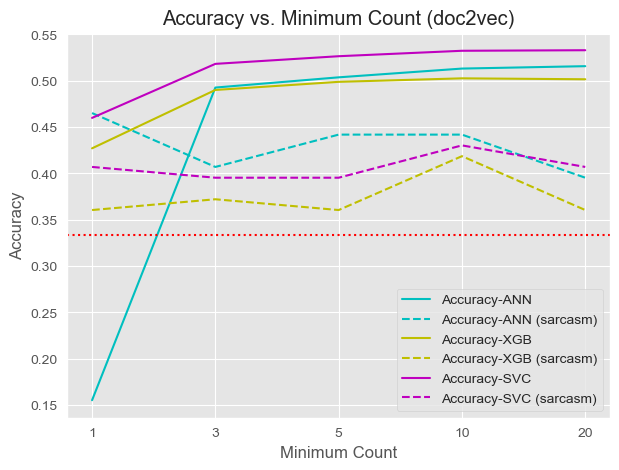

In [32]:
xgb_window = np.array(xgb_window)
ann_window = np.array(ann_window)
svc_window = np.array(svc_window)


plt.rcParams["figure.figsize"] = (7, 5)
window = [1, 3, 5, 10, 20]

x = np.arange(5)
plt.plot(x, ann_window[0], 'c', label='Accuracy-ANN ')
plt.plot(x, ann_window[3], 'c--', label='Accuracy-ANN (sarcasm)')

plt.plot(x, xgb_window[0], 'y', label='Accuracy-XGB')
plt.plot(x, xgb_window[3], 'y--', label='Accuracy-XGB (sarcasm)')

plt.plot(x, svc_window[0], 'm', label='Accuracy-SVC')
plt.plot(x, svc_window[3], 'm--', label='Accuracy-SVC (sarcasm)')

plt.xticks(np.arange(5), window)
plt.legend(loc='lower right')
plt.axhline(y=1/3, color='r', linestyle='dotted')
plt.xlabel("Minimum Count")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Minimum Count (doc2vec)")
plt.savefig('accuracy_doc2vec_minimumcount.png', dpi=1000)
plt.show()

In [22]:
%%time
xgb_count = [[], [], [], [], [], []]
ann_count = [[], [], [], [], [], []]
svc_count = [[], [], [], [], [], []]

vocab = train_token + test_token + sarcasm_token

for window in tqdm([2, 3, 4, 5, 6]):

    doc_model = doc2vec.Doc2Vec(vector_size=300, window=window, min_count=1, workers=32)
    doc_model.build_vocab([i for i in tagged_docs])
    doc_model.train(tagged_docs, total_examples=doc_model.corpus_count, epochs=100)


    train_vector = [doc_model[i] for i in range(47688)]
    train_vector = np.array(train_vector)
    test_vector = [doc_model[i] for i in range(47688, 47688+10050)]
    test_vector = np.array(test_vector)
    sarcasm_vector = [doc_model[i] for i in range(47688+10050, 47688+10050+86)]
    sarcasm_vector = np.array(sarcasm_vector)

    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(300, )),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)
])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(train_vector, y_train, epochs=20, verbose=0)
    pred = np.array(tf.argmax(model.predict(test_vector), axis=1))
    pred_sarcasm = np.array(tf.argmax(model.predict(sarcasm_vector), axis=1))
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    ann_count[0].append(r1)
    ann_count[1].append(r2)
    ann_count[2].append(r3)
    ann_count[3].append(r4)
    ann_count[4].append(r5)
    ann_count[5].append(r6)

    model = xgb.XGBClassifier()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    xgb_count[0].append(r1)
    xgb_count[1].append(r2)
    xgb_count[2].append(r3)
    xgb_count[3].append(r4)
    xgb_count[4].append(r5)
    xgb_count[5].append(r6)

    model = SVC()
    model.fit(train_vector, y_train)

    pred = model.predict(test_vector)
    pred_sarcasm = model.predict(sarcasm_vector)
    r1, r2, r3, r4, r5, r6 = result(y_test, y_sarcasm, pred, pred_sarcasm, show=False)
    svc_count[0].append(r1)
    svc_count[1].append(r2)
    svc_count[2].append(r3)
    svc_count[3].append(r4)
    svc_count[4].append(r5)
    svc_count[5].append(r6)

  0%|          | 0/5 [00:00<?, ?it/s]2023-01-07 09:05:01.618361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 82/315 [======>.......................] - ETA: 0s

2023-01-07 09:07:38.136420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 7ms/step
[09:07:39] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 20%|██        | 1/5 [23:49<1:35:19, 1429.86s/it]2023-01-07 09:28:52.744128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 82/315 [======>.......................] - ETA: 0s

2023-01-07 09:31:28.609015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 7ms/step
[09:31:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 40%|████      | 2/5 [47:35<1:11:22, 1427.52s/it]2023-01-07 09:52:38.610812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 79/315 [======>.......................] - ETA: 0s

2023-01-07 09:55:14.954055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 8ms/step
[09:55:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 60%|██████    | 3/5 [1:10:55<47:09, 1414.67s/it]2023-01-07 10:16:00.540242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 79/315 [======>.......................] - ETA: 0s

2023-01-07 10:18:37.345823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 7ms/step
[10:18:38] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 80%|████████  | 4/5 [1:35:17<23:53, 1433.62s/it]2023-01-07 10:40:23.408906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 81/315 [======>.......................] - ETA: 0s

2023-01-07 10:42:59.408736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 9ms/step
[10:43:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 5/5 [1:58:40<00:00, 1424.02s/it]

CPU times: user 2h 44min 39s, sys: 18min 17s, total: 3h 2min 56s
Wall time: 1h 58min 40s


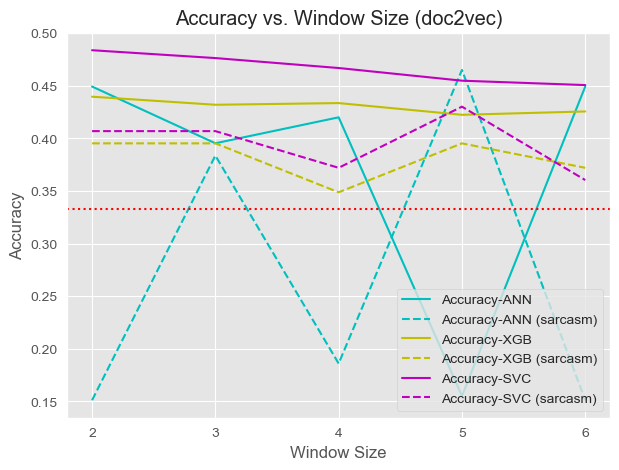

In [33]:
xgb_count = np.array(xgb_count)
ann_count = np.array(ann_count)
svc_count = np.array(svc_count)


plt.rcParams["figure.figsize"] = (7, 5)
min_count = [2, 3, 4, 5, 6]

x = np.arange(5)
plt.plot(x, ann_count[0], 'c', label='Accuracy-ANN ')
plt.plot(x, ann_count[3], 'c--', label='Accuracy-ANN (sarcasm)')

plt.plot(x, xgb_count[0], 'y', label='Accuracy-XGB')
plt.plot(x, xgb_count[3], 'y--', label='Accuracy-XGB (sarcasm)')

plt.plot(x, svc_count[0], 'm', label='Accuracy-SVC')
plt.plot(x, svc_count[3], 'm--', label='Accuracy-SVC (sarcasm)')

plt.xticks(np.arange(5), min_count)
plt.axhline(y=1/3, color='r', linestyle='dotted')
plt.legend(loc='lower right')
plt.xlabel("Window Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Window Size (doc2vec)")
plt.savefig('accuracy_doc2vec_window.png', dpi=1000)
plt.show()